**Ideas for future**

Immediate:

- Finish transporting all features from Data 2 - Main
- Judge the quality of the variables (visualize) for the filtered set
- Train 

Future:

- Play with models
- Grid Search
- Implement Ana's idea*

- Alternate strategy: don't predict dT, but the alternatives in Presentation Notes 2

For now, I will try to predict $dT = T_{zero} - T_{zc}$ based on the coefficients $a_0$ etc. and $\chi^2$. 

In [1]:
#--- Preamble

# Visualizers
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150   # Increase figure resolution
plt.rcParams['savefig.dpi'] = 150

# Data computation and manipulation
import numpy as np
import pandas as pd
import scipy.optimize as sop
import scipy.stats as sps

# Machine Learning
from sklearn.model_selection import train_test_split
import tensorflow as tf

tf.random.set_seed(42)  # Set seed - reproducibility

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# For permutations
import itertools

In [2]:
#-> Paths to access saved models on my different machines

paths_on_my_laptop = ["C:/Users/andre/Python Notebooks/TimeResolutionImprovement-ML/MLdata_Po3CFD.dat",
                     "C:/Users/andre/Python Notebooks/TimeResolutionImprovement-ML/Saved Models/"]

#-> Read the data
# Note: There is an extra redundant column to drop

# Import
path_temp = paths_on_my_laptop[0]
data = pd.read_csv(path_temp, sep=",").drop(columns=["Ch"])

# Create column dT = T_zero - T_zc
data["dT"] = data["T_zero"] - data["T_zc"]

# Filter for only the energies in the peak
FILTER_ENERGIES = False

if FILTER_ENERGIES == True:
    data = data.loc((data["E"] > 4490) & (data["E"] < 4570))

# Visualize and prepare data

**Conclusions**

*Unfiltered data-set*

- From scatter plots: the structure is somewhat boring (vertical stripe = thin uncorrelated Gaussian), which doesn't help with the predictive power. There is, however, a bump around the high values that may help. The most "interesting" covariates are, from most to least: $a_3 \approx a_2$, $a_0$, $a_1$, $\chi^2$.
- From the correlation matrix: the covariates are, from best to worst: $a_3$, $a_2$, $a_0 \approx \chi^2$, $a_1$. This is pretty consistent with our findings above.

*Filtered data-set*

%evaluate difference between the energy filtered/unfiltered data sets
%look at the most promising covariates for training

In [25]:
data.head()

,E,T_zero,T_zc,a0,a1,a2,a3,dTime,chi2,dT
0,905,-51.9211,154.586,0.036770,0.001166,-0.000047,1.950250e-06,54.9609,0.000432,-206.5071
1,4265,37.0659,166.029,-0.013490,-0.000368,-0.000031,4.345620e-06,-36.4764,0.000034,-128.9631
2,4543,56.0142,180.400,0.002568,-0.000060,-0.000048,3.093750e-06,-52.4072,0.000037,-124.3858
3,1620,42.3779,178.432,-0.001083,-0.003388,0.000140,5.295790e-07,-38.9714,0.000107,-136.0541
4,4511,42.1653,165.936,0.002186,-0.000863,-0.000016,3.598750e-06,-41.5207,0.000029,-123.7707


In [26]:
data.shape

(6015, 10)

In [27]:
data.columns

Index(['E', 'T_zero', 'T_zc', 'a0', 'a1', 'a2', 'a3', 'dTime', 'chi2', 'dT'], dtype='object')

## Scatter Plots and Histograms

**Scatter Matrix** (from Pandas)

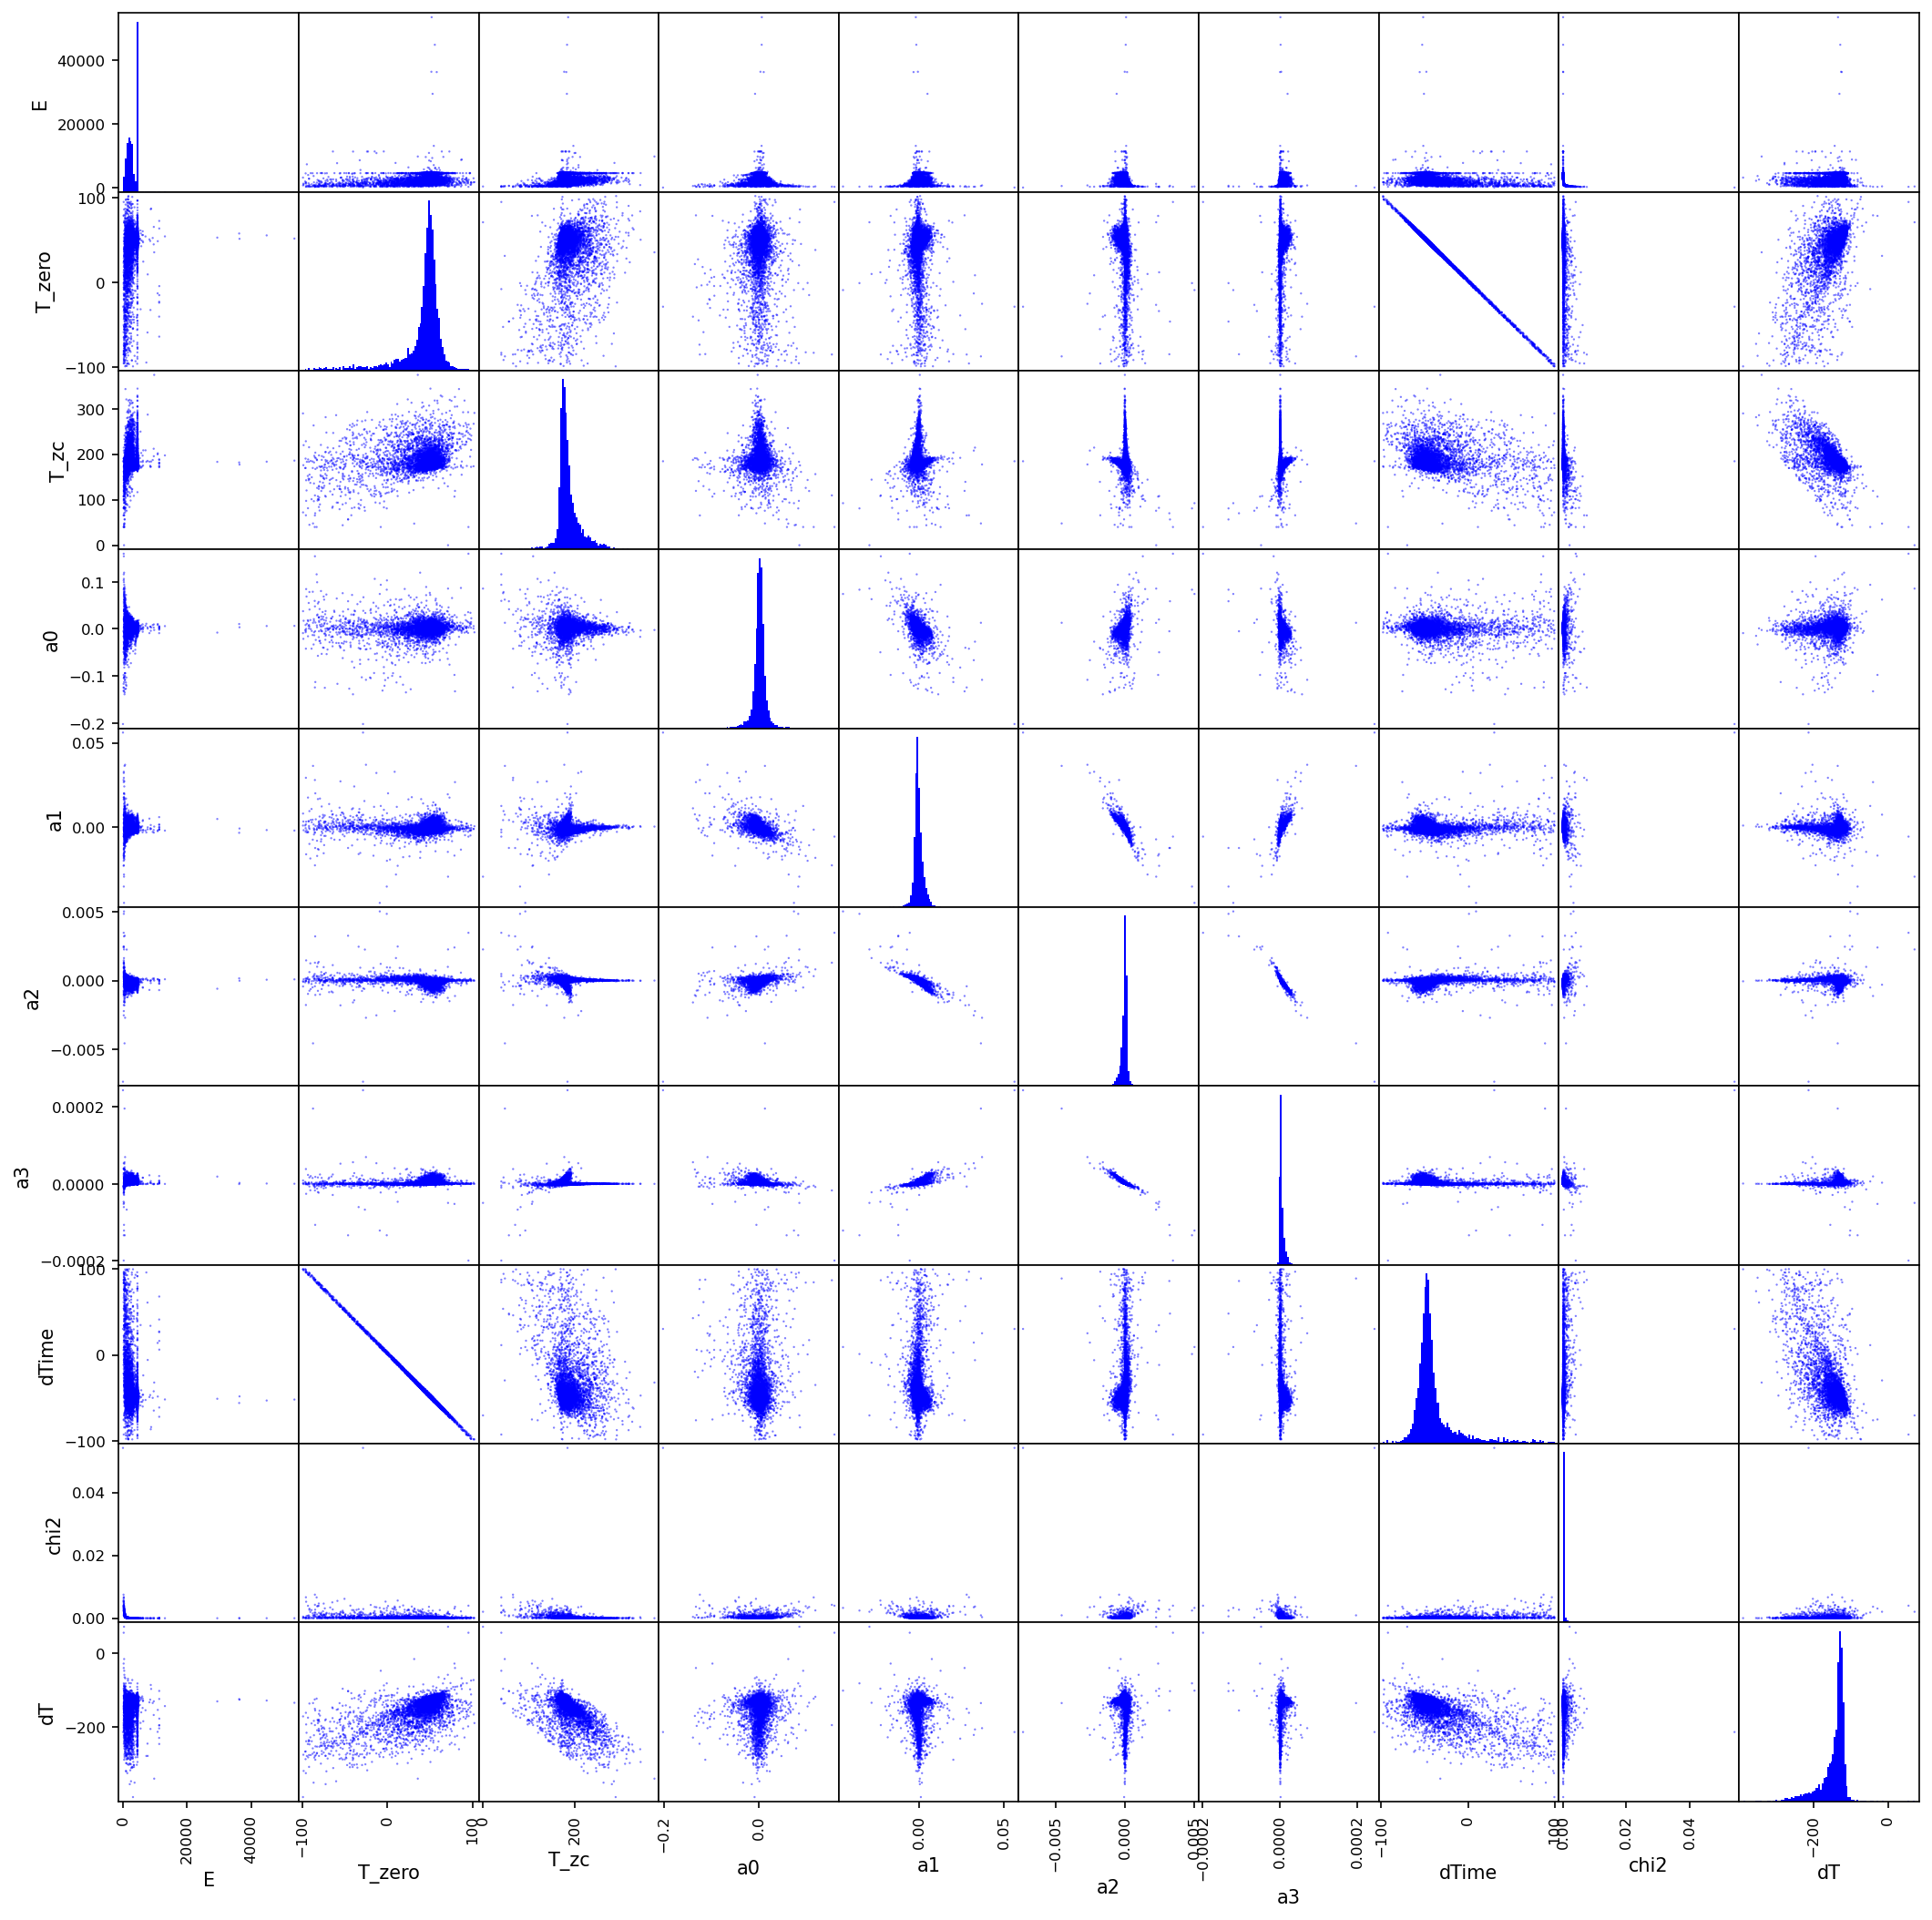

In [53]:
pd.plotting.scatter_matrix(data, color='blue', figsize=(17, 17), s=5,
                          hist_kwds={'bins':100, 'color':'blue'})

# Save and show nicely
if FILTER_ENERGIES == True:
    plt.savefig('Scatter matrix - energy filtered.png', bbox_inches='tight')
else:
    plt.savefig('Scatter matrix - unfiltered.png', bbox_inches='tight')

plt.show()

**Scatter Plots** (custom made)

In [62]:
def scatter_matrix_plotter(indices_1, indices_2, save_fig=False):
    """
    Creates a scatter mattrix plot of each feature given by
    indices_1 and indices_2.
    
    --- Inputs:
    
    indices_1, indices_2 = Array-like. Each contains a list of all index_1, 
    respectively index_2 arguments, which represent the names of the columns 
    that are to be plotted by df.plot.scatter(). 
    **Note**:Both must have the same length!
    
    save_fig = Boolean. If true, it saves the subplots as a PNG
    
    --- Returns:
    
    A subplot with all scatter plots required.
    """
    
    num_rows = max(len(indices_1) // 3, 1)
    
    fig, axs = plt.subplots(num_rows, 3,
                       figsize=(15, 5 * num_rows),
                       constrained_layout=True)

    for index_1, index_2, ax in zip(indices_1, indices_2, axs.flatten()):
        ax.scatter(data[index_1], data[index_2], s=5, c="blue")
        ax.set_title(f"{index_2} vs. {index_1}")
        
        ax.set_xlabel(index_1, fontsize=12)
        ax.set_ylabel(index_2, fontsize=12)
    
    if FILTER_ENERGIES == True:
        fig.suptitle('Scatter plot of multiple features - energy filtered', size=38)
    else:
        fig.suptitle('Scatter plot of multiple features - unfiltered', size=38)
        
    if save_fig == True:
        if FILTER_ENERGIES == True:
            plt.savefig('Scatter plots of multiple features - energy filtered.png', bbox_inches='tight')
        else:
            plt.savefig('Scatter plots of multiple features - unfiltered.png', bbox_inches='tight')
    
    plt.show()

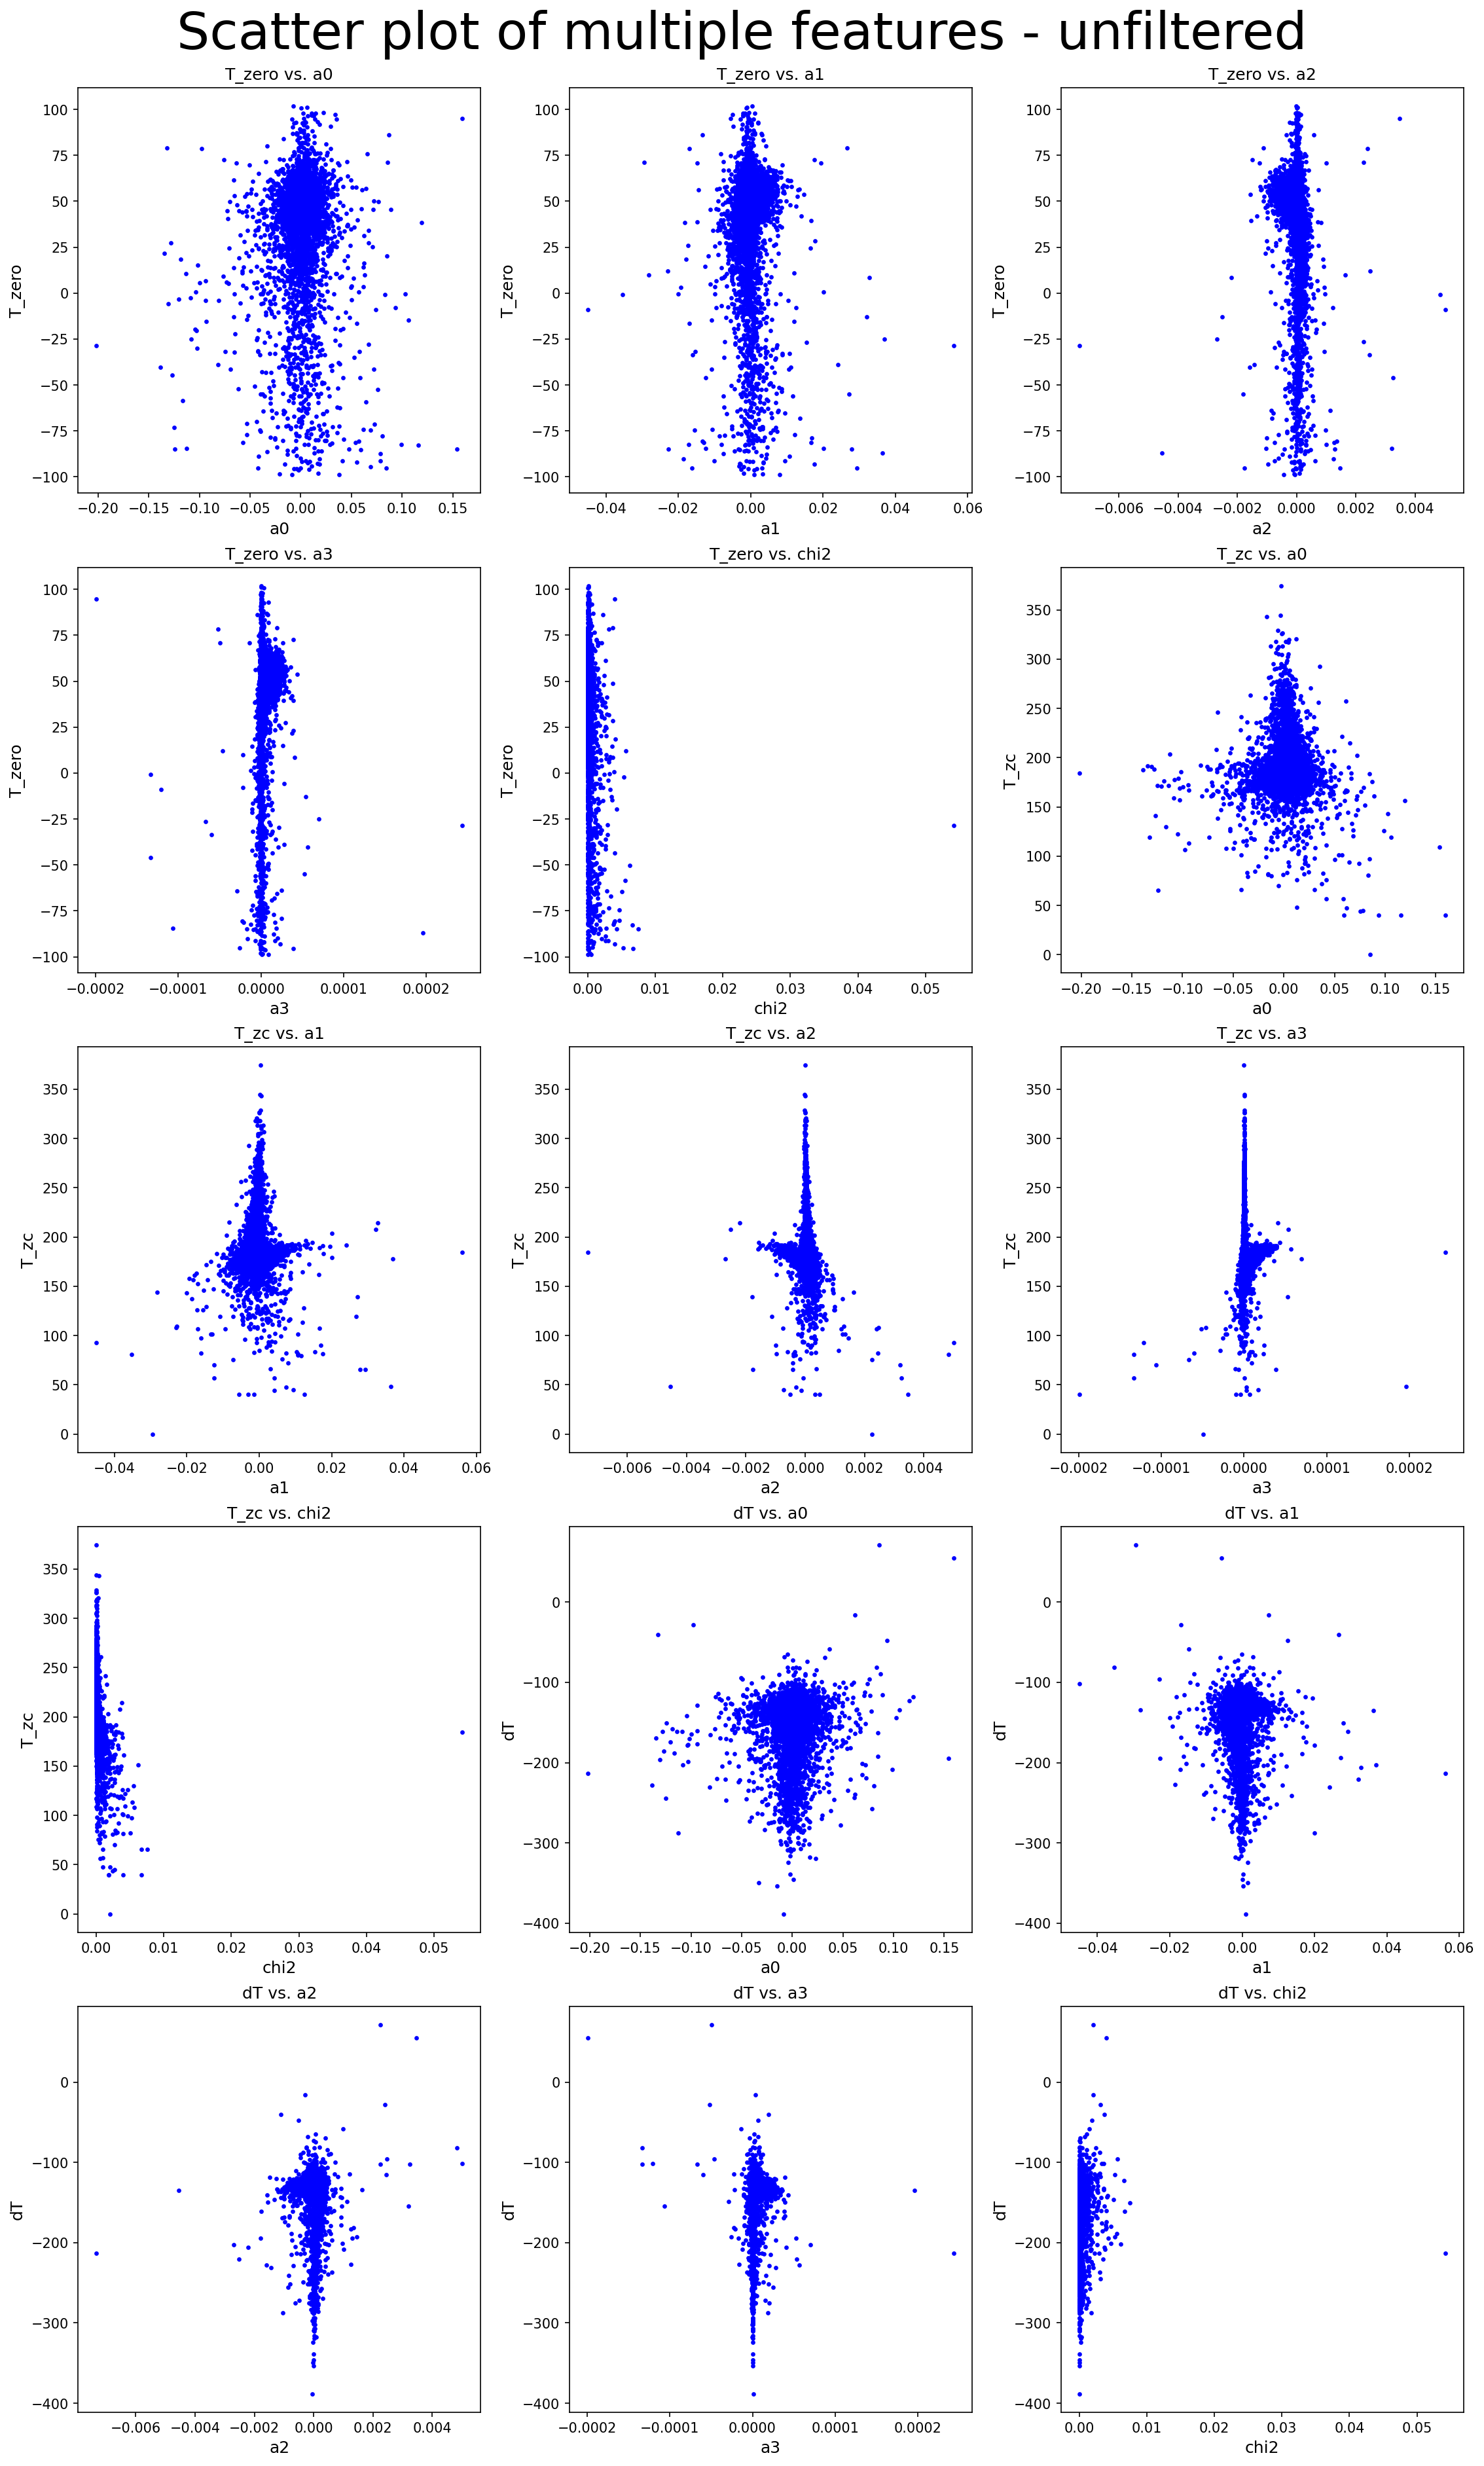

In [63]:
#--- Create scatter plot of only interesting features

x_features = ["a0", "a1", "a2", "a3", "chi2"]  # Training covariates - candidates
y_features = ["T_zero", "T_zc", "dT"]          # Response variables - candidates

# Create arrays with the names
x_names = x_features * len(y_features)
y_names = [y_features[0]] * len(x_features)

for i in range(1,len(y_features)):
    y_names = y_names + [y_features[i]] * len(x_features)
    
# The scatter plot
scatter_matrix_plotter(x_names, y_names, save_fig=True)

## Correlation between variables 

In [3]:
# Build correlation matrix
data_corr = data.corr(method="pearson")
# Convert to numpy array
data_corr_np = data_corr.to_numpy()

### Correlation Matrices

**Version 1**

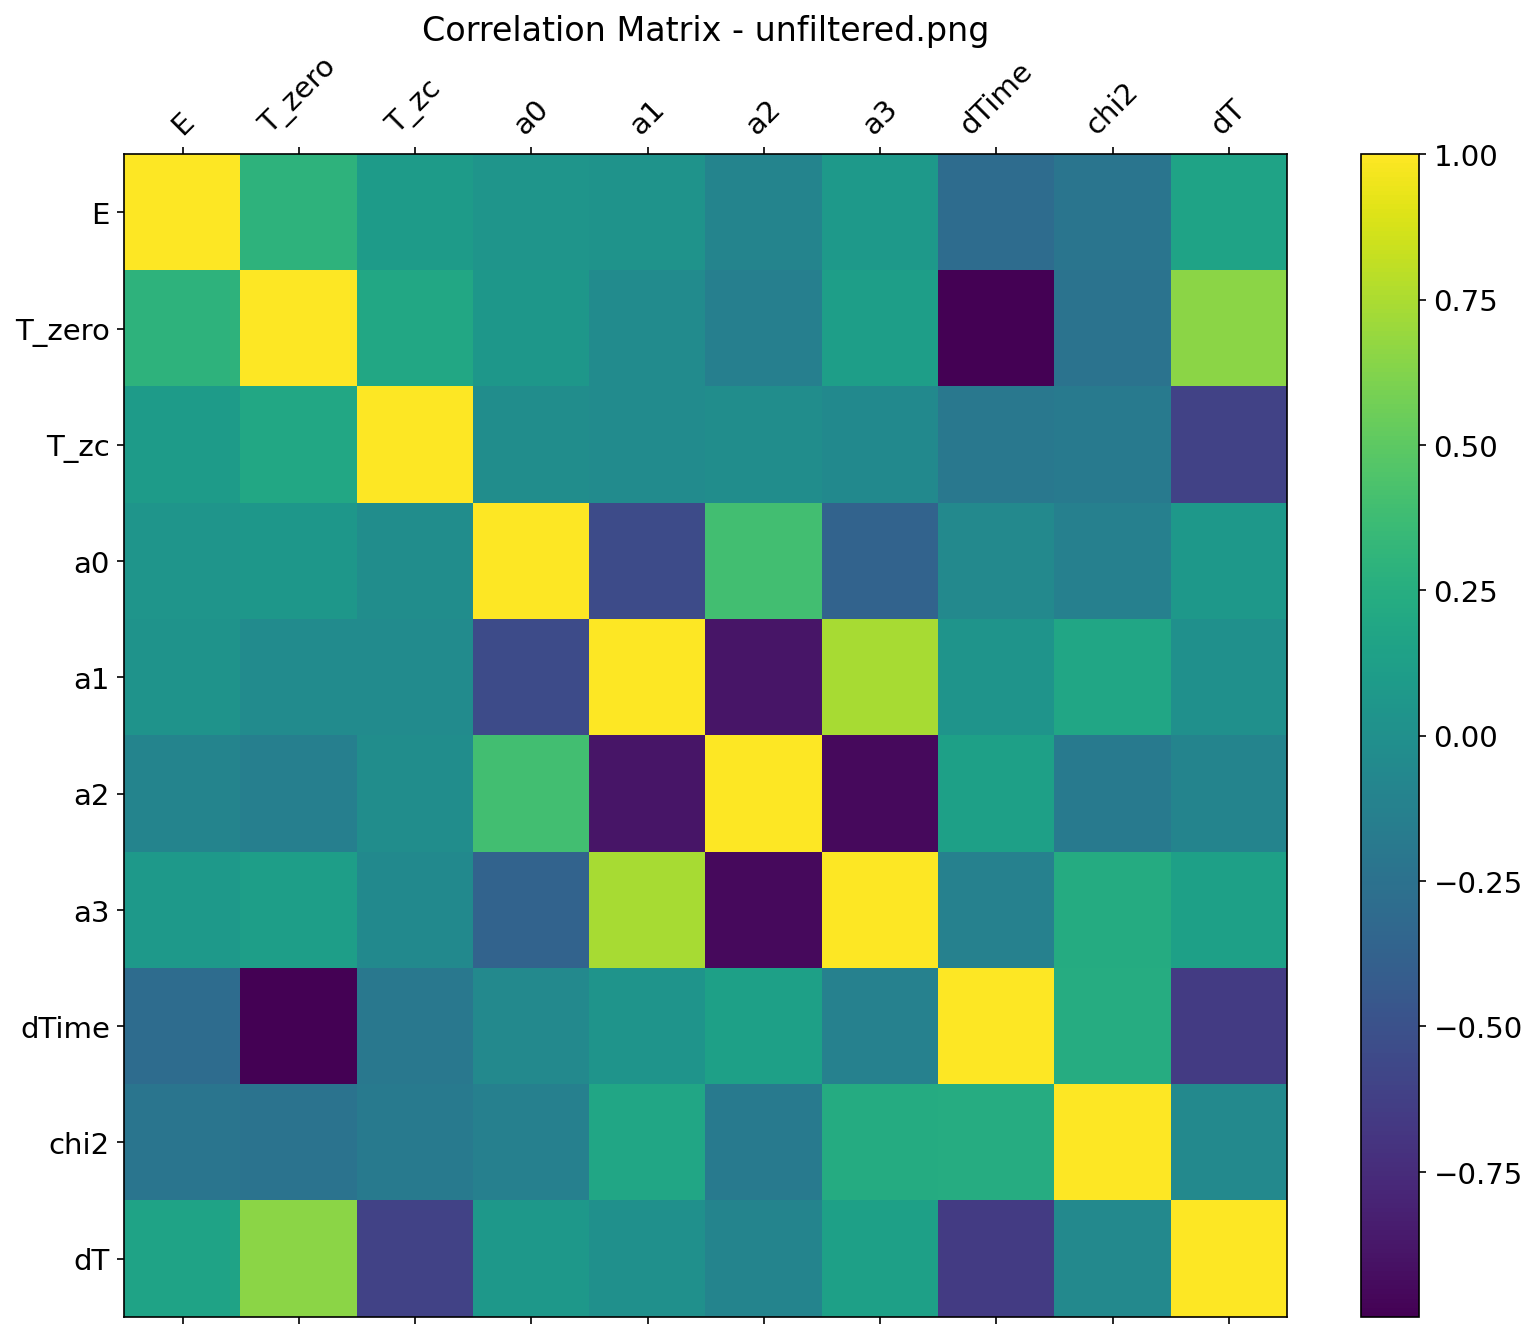

In [60]:
fig = plt.figure(figsize=(12.7, 10)) # 19 15

plt.matshow(data_corr, fignum=fig.number)

plt.xticks(range(data_corr.shape[1]), data_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(data_corr.shape[1]), data_corr.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

if FILTER_ENERGIES == True:
    plt.title('Correlation Matrix - energy filtered', fontsize=16)
else:
    plt.title('Correlation Matrix - unfiltered.png', fontsize=16)

# Save figure. Put plt.show() after
if FILTER_ENERGIES == True:
    plt.savefig('Correlation Matrix - energy filtered.png', bbox_inches='tight')
else:
    plt.savefig('Correlation Matrix - unfiltered.png', bbox_inches='tight')
    
plt.show()

**Version 2**

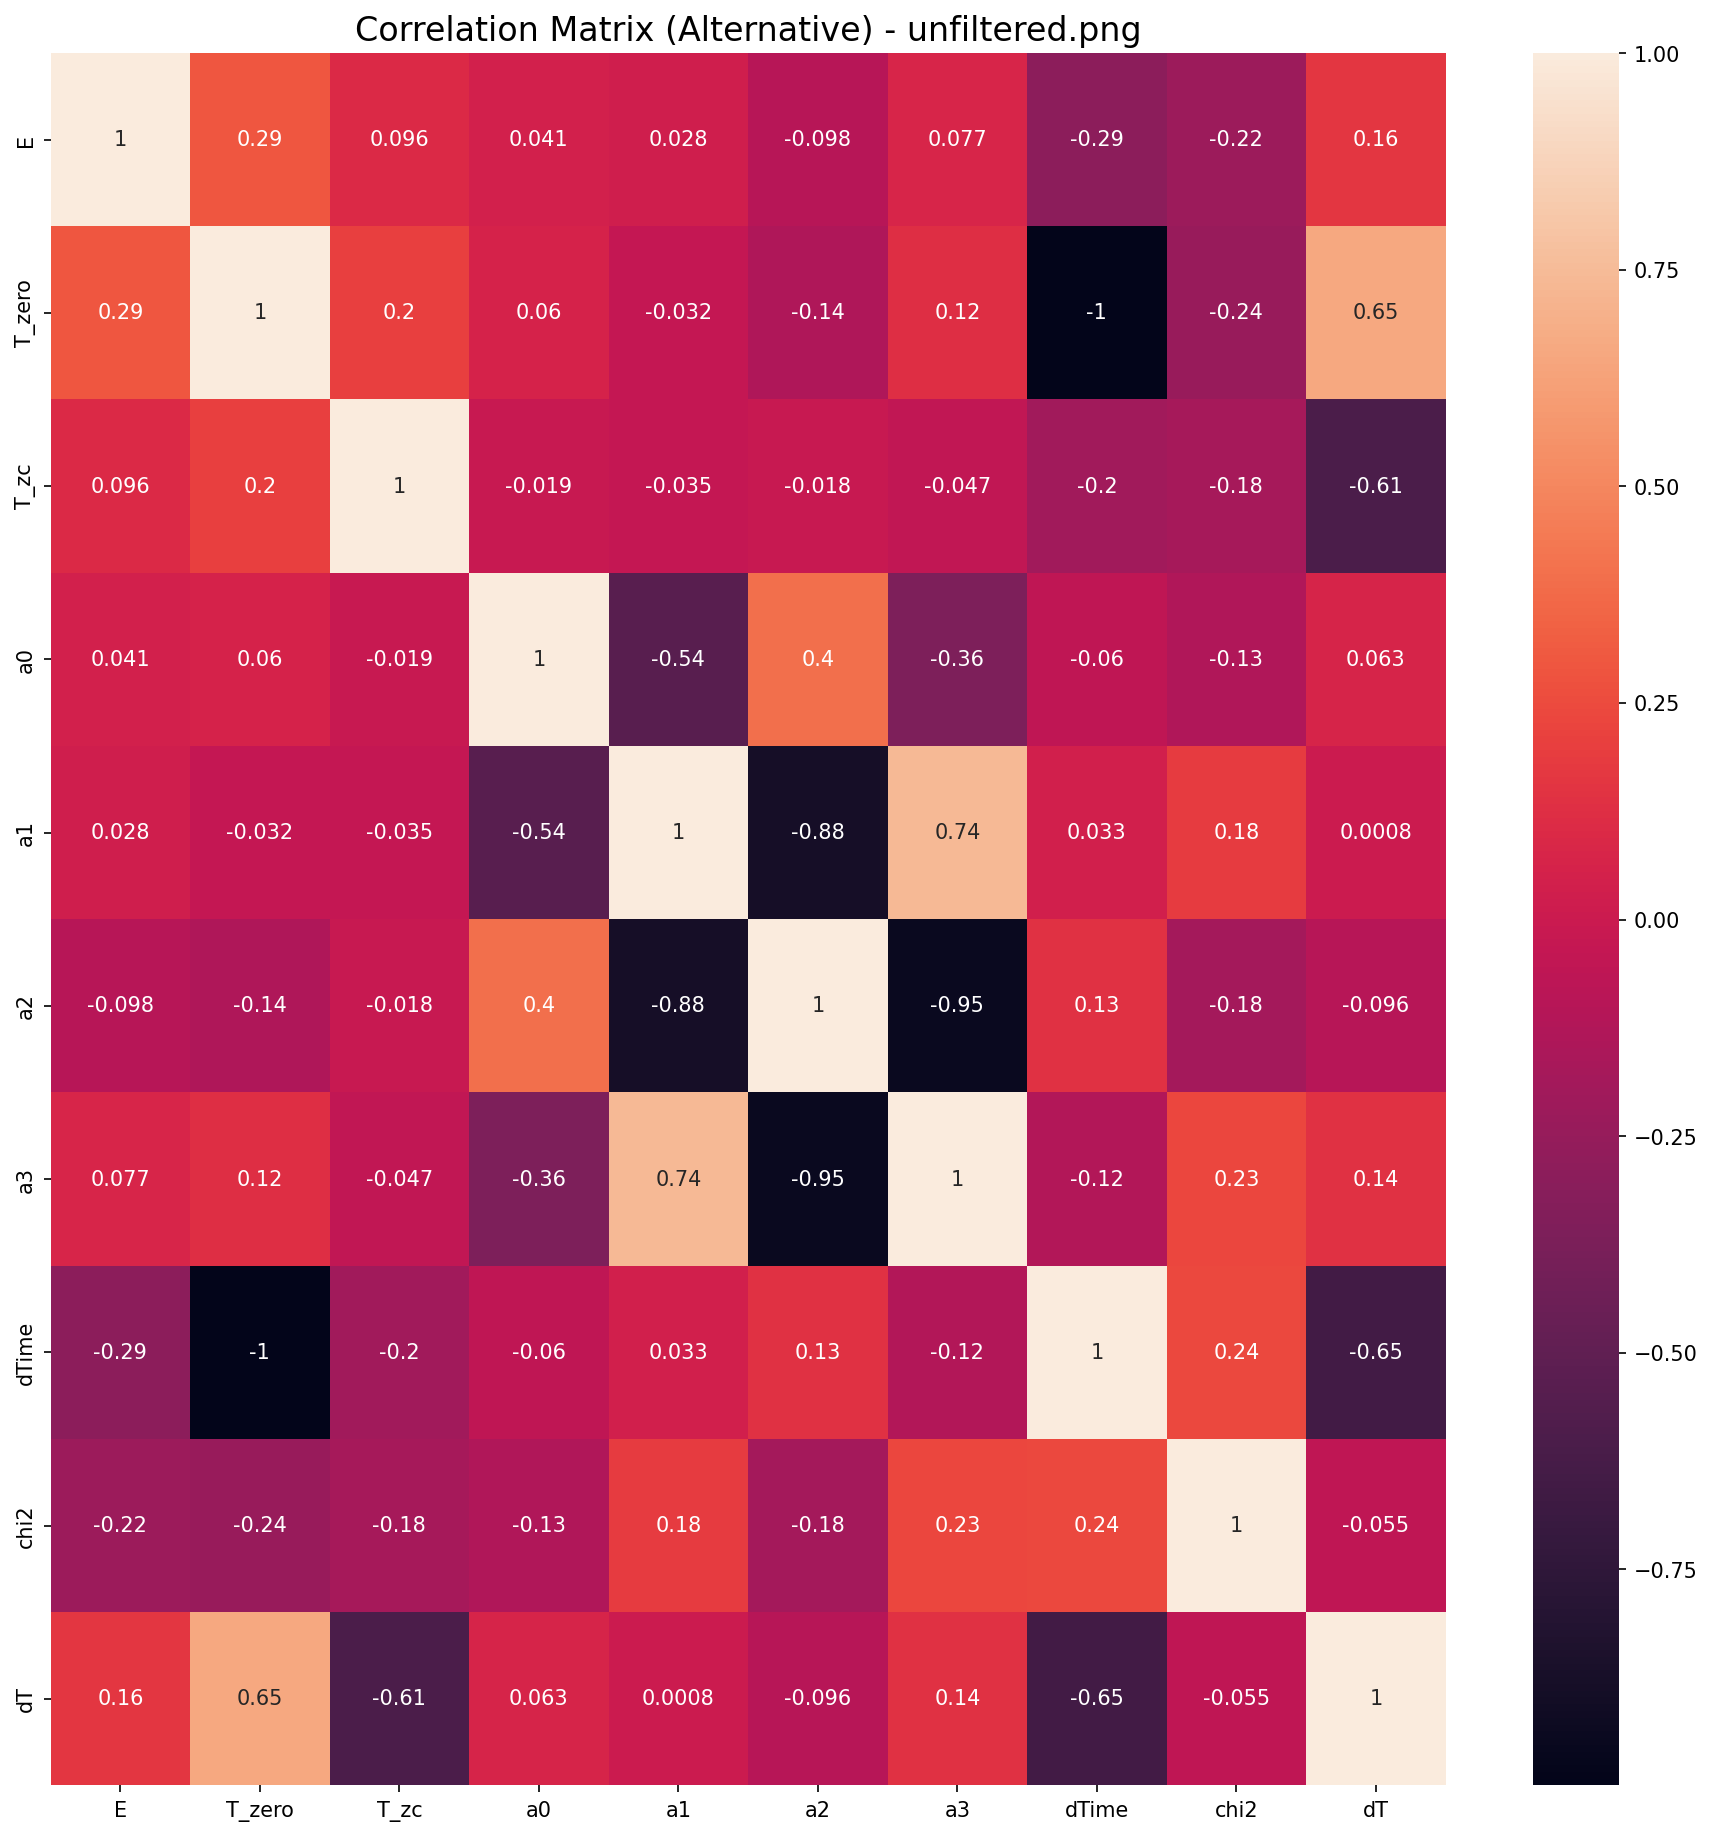

In [61]:
plt.figure(figsize=(15, 15))

ax = plt.subplot()

if FILTER_ENERGIES == True:
    ax.set_title('Correlation Matrix (Alternative) - energy filtered', fontsize=16)
else:
    ax.set_title('Correlation Matrix (Alternative) - unfiltered.png', fontsize=16)

sns.heatmap(data_corr, annot=True, ax = ax)

if FILTER_ENERGIES == True:
    plt.savefig('Correlation Matrix (Alternative) - energy filtered.png', bbox_inches='tight')
else:
    plt.savefig('Correlation Matrix (Alternative) - unfiltered.png', bbox_inches='tight')

### Pairwise Correlation

**Important Functions**

In [9]:
# --- Create a display function

# Treat columns as indices
# Use indices to refer back to the names
col_index= {i: c for i, c in enumerate(data_corr.columns)}

def correlation_plotter(ax, index=1, threshold=0, print_val=False,
                       zoom=False):
    """
    It creates a plot (on 'ax' axis; easy to integrate with subplots)
    of the correlation using the 'index' row. Additional features:
    
    - plots the absolute value only, but in different colors depending on the sign
    - prints the values and columns exceeding an imposed threshold
    - dynamically changes the scaling of the y axis for zooming in
    
    --- Inputs:
    
    - ax = The axis on which to create the (sub)plot
    - index = Integer. It denotes the number of the row to be compared 
    with all other features. To see which column index corresponds to, 
    evaluate 'col_index[index]'
    - threshold = Float. It denoted the value to be exceeded by the
    absolute value of the correlations
    - print_val = Boolean. If true, it displays which columns exceed the
    threshold mentioned above
    - zoom = Boolean. If true, it dynamically changes the yrange such that
    one focuses only on values between 0 and roughly the maximum of the achieved
    correlations
    
    --- Returns:
    
    - axis is changed according to the specifications
    - if print_val=True, the columns above the threshold are printed
    """
    
    # Interested only in correlations excluding the variable itself
    mask = data_corr_np[index] < 1
    corr = data_corr_np[index][mask]  
    
    # xticks for plotting convenience
    xticks = np.array([1 + 3*i for i in range(len(corr))])
    
    # Separate the correlations via signs for different colors
    mask_pos = corr >= 0
    mask_neg = np.logical_not(mask_pos)
    
    corr_pos = corr[mask_pos]
    corr_neg = np.abs(corr[mask_neg])
    
    xticks_pos = xticks[mask_pos]
    xticks_neg = xticks[mask_neg]
    
    # Identify all points above the threshold
    if threshold > 0:
        _ = np.nonzero(np.abs(corr) > threshold)[0]
        # Offset values after the deleted index by 1
        # so it prints the correct column
        _[_ > index] += 1
        
        if print_val == True:
            if len(_) == 0:
                print(f"No correlations above {threshold}")
            else:
                print(f"{col_index[index]}. Columns over threshold: {[col_index[i] for i in _]}")
    
    # The plotting itself
    ax.set_title(f"Correlations - {col_index[index]}", fontsize=15)
    
    if threshold > 0:
        ax.hlines(y=threshold, xmin=0, xmax=xticks[-1] + 1, 
                  color="black", linestyle=":", label="Threshold")
    
    ax.scatter(xticks_pos, corr_pos, c="blue", s=5, label="Positive")
    ax.scatter(xticks_neg, corr_neg, c="red", s=5, label="Negative")

    ax.grid(axis='y')
    ax.legend(fontsize=8)

    ax.set_ylabel(f"{col_index[index]}", fontsize=12)
    ax.set_xlim(0, xticks[-1] + 1)
    
    # Dynamically change the yrange -- TO BE FIXED
    if zoom == True:
        ymax = min(1, 0.1*np.ceil(10 * np.max(np.abs(corr))))
        ax.set_ylim(0, ymax)
    else:
        ax.set_ylim(0, 1)
    
    _ = np.nonzero(np.logical_not(mask))[0][0] # Drop the removed variable from ticks
    ax.set_xticks(xticks, data_corr.drop(columns=[col_index[_]]).columns, fontsize=10, rotation=45)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    


In [6]:
col_index

{0: 'E',
 1: 'T_zero',
 2: 'T_zc',
 3: 'a0',
 4: 'a1',
 5: 'a2',
 6: 'a3',
 7: 'dTime',
 8: 'chi2',
 9: 'dT'}

dT. Columns over threshold: ['E', 'T_zero', 'T_zc', 'a0', 'a2', 'a3', 'dTime', 'chi2']


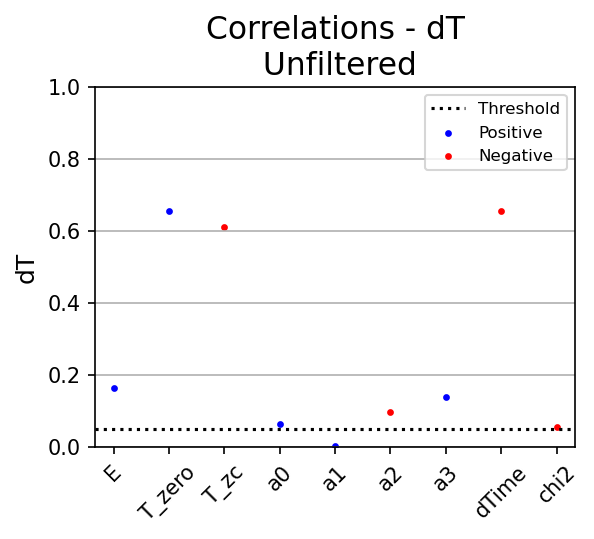

In [13]:
#-> Display correlations of dT versus the rest

# Index of dT
index = 9
# Correlation over 5%: say it's significant enough 
threshold = 0.05

#-> The figure

fig = plt.figure()
ax = fig.add_axes([0, 0, 0.5, 0.5])
correlation_plotter(ax, index=index, threshold=threshold, print_val=True, zoom=True)

if FILTER_ENERGIES == True:
    ax.set_title(f"Correlations - {col_index[index]}\n Energy filtered", fontsize=15)
else:
    ax.set_title(f"Correlations - {col_index[index]}\n Unfiltered", fontsize=15)
    
#-> Save figure

if FILTER_ENERGIES == True:
    plt.savefig('Correlations - dT vs all - Energy filtered.png', bbox_inches='tight')
else:
    plt.savefig('Correlations - dT vs all - Unfiltered.png', bbox_inches='tight')

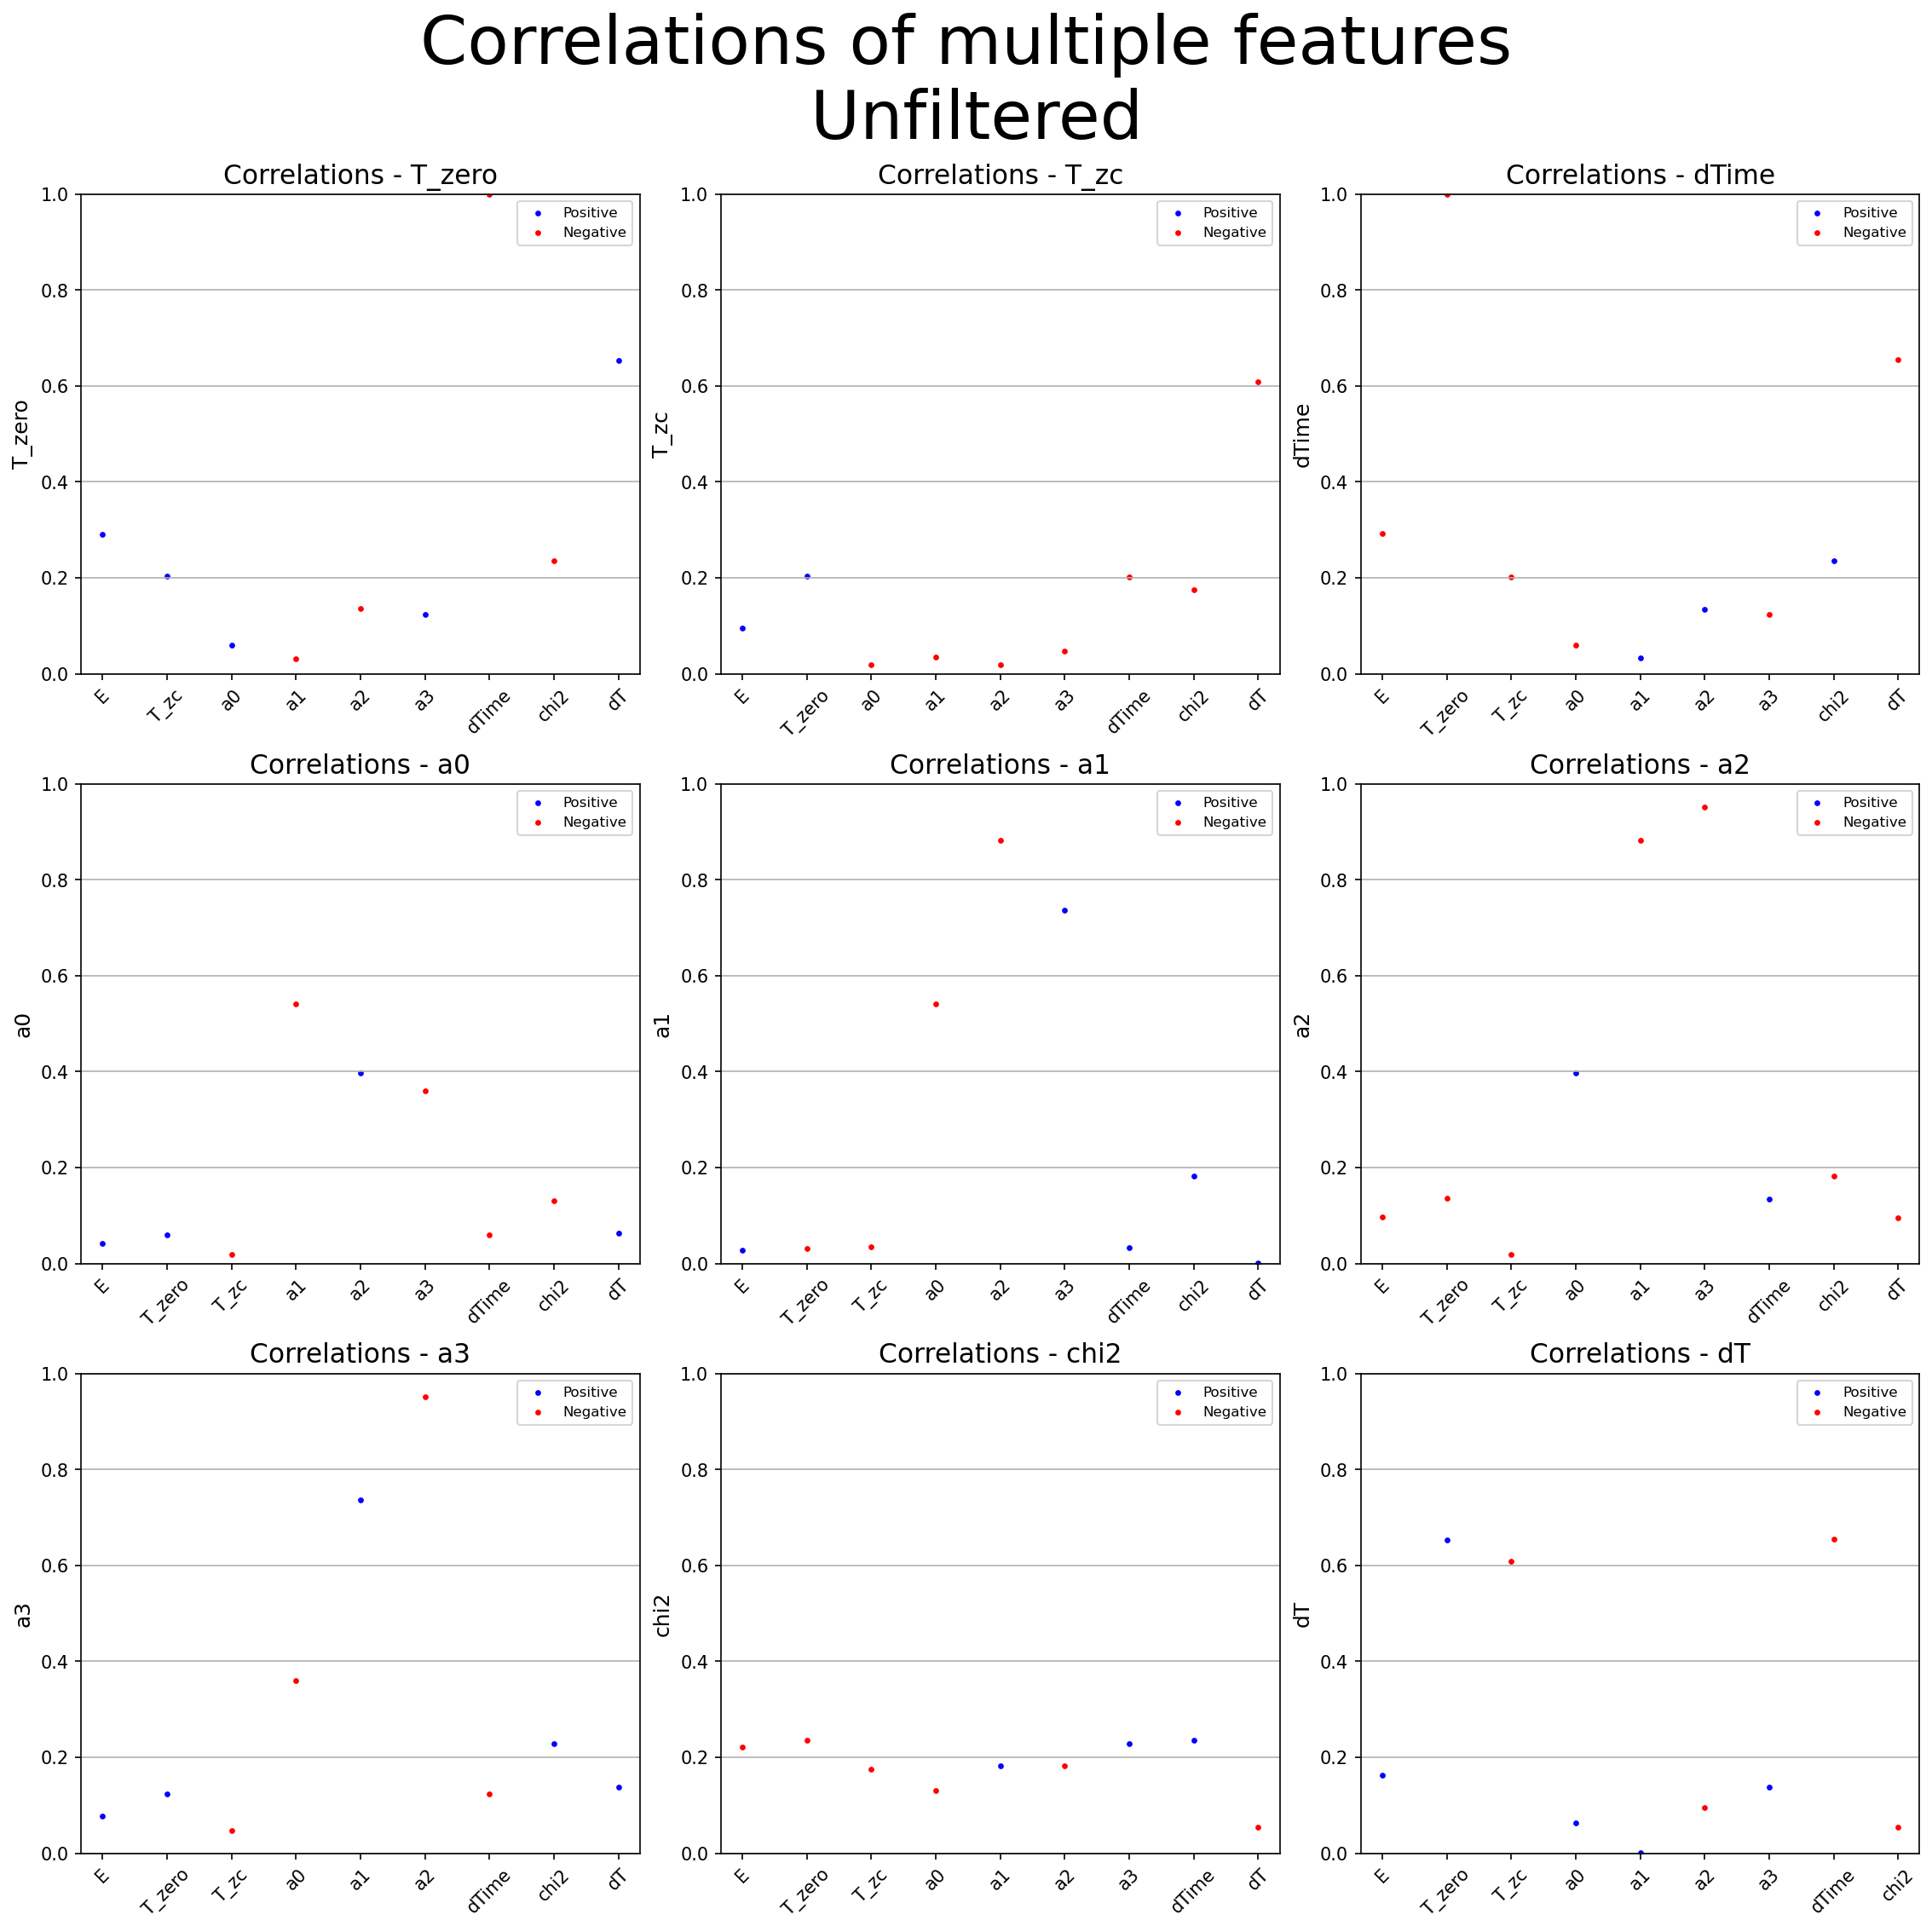

In [16]:
#-> Create subplots of correlations

# Define the indices where we want to analyze correlations
indices = [1, 2, 7, 3, 4, 5, 6, 8, 9]
num_rows = len(indices) // 3

fig, axs = plt.subplots(num_rows, 3,
                       figsize=(15, 5 * num_rows),
                       constrained_layout=True)

# Plot each correlation
for index, ax in zip(indices, axs.flatten()):
    correlation_plotter(ax, index=index)

if FILTER_ENERGIES == True:
    fig.suptitle('Correlations of multiple features\n Energy filtered', size=38)
else:
    fig.suptitle('Correlations of multiple features\n Unfiltered', size=38)

#-> Save figure

if FILTER_ENERGIES == True:
    plt.savefig('Correlations of multiple features - Energy filtered.png', bbox_inches='tight')
else:
    plt.savefig('Correlations of multiple features - Unfiltered.png', bbox_inches='tight')

plt.show()